## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import joblib
import os
import math


## Import Raw Dataset

In [2]:
df_raw = pd.read_csv('japan_earthquakes_combined_filtered.csv')
print("Raw data loaded successfully.")
print(df_raw.shape)
print("Null value counts:\n", df_raw.isnull().sum())


Raw data loaded successfully.
(41457, 22)
Null value counts:
 time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                19115
gap                12232
dmin               29334
rms                  881
net                    0
id                     0
updated                0
place                  0
type                   0
horizontalError    30649
depthError         16182
magError           29509
magNst              5916
status                 0
locationSource         0
magSource              0
dtype: int64


## Check Dataset Info and Missing Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41457 entries, 0 to 41456
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             41457 non-null  object 
 1   latitude         41457 non-null  float64
 2   longitude        41457 non-null  float64
 3   depth            41457 non-null  float64
 4   mag              41457 non-null  float64
 5   magType          41457 non-null  object 
 6   nst              22342 non-null  float64
 7   gap              29225 non-null  float64
 8   dmin             12123 non-null  float64
 9   rms              40576 non-null  float64
 10  net              41457 non-null  object 
 11  id               41457 non-null  object 
 12  updated          41457 non-null  object 
 13  place            41457 non-null  object 
 14  type             41457 non-null  object 
 15  horizontalError  10808 non-null  float64
 16  depthError       25275 non-null  float64
 17  magError    

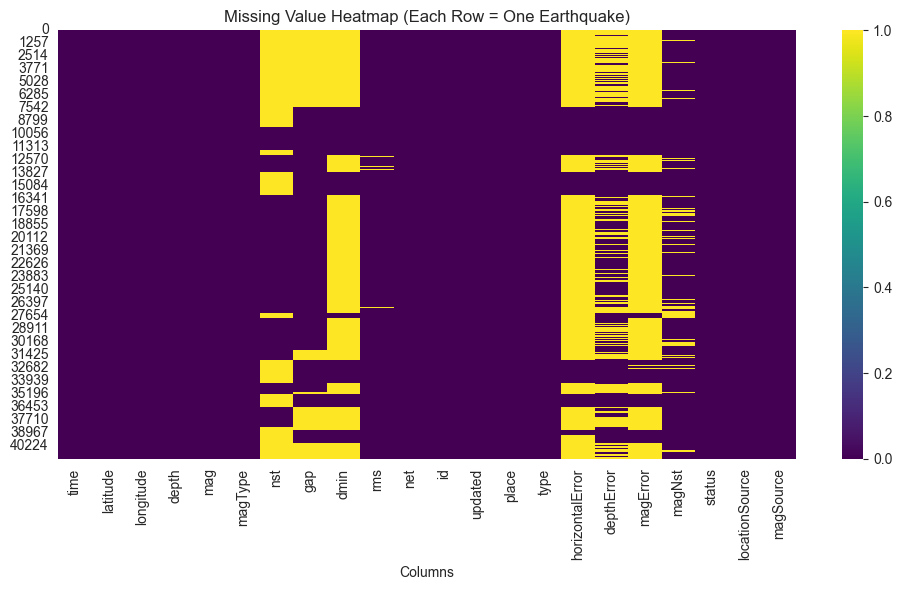

In [3]:
df_raw.info()
df_raw.isnull().sum()
plt.figure(figsize=(10, 6))
sns.heatmap(df_raw.isnull(), cbar=True, cmap='viridis')
plt.title('Missing Value Heatmap (Each Row = One Earthquake)')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()


## Correlation Heatmap of Numerical Features

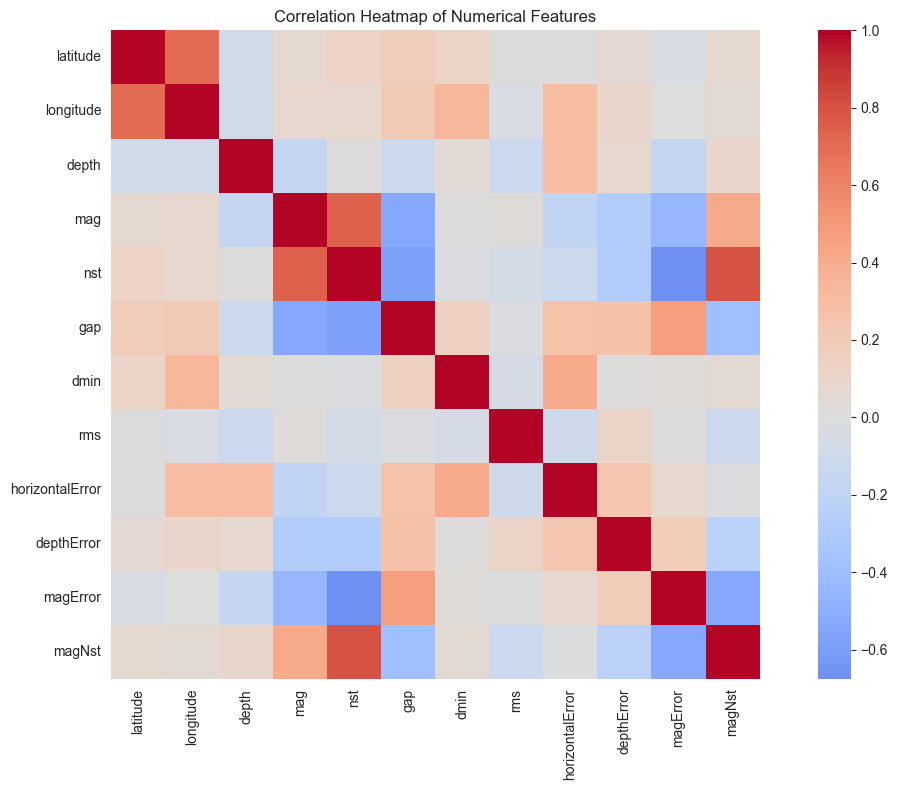

In [4]:
numeric_df = df_raw.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


## Magnitude Distribution (Original)

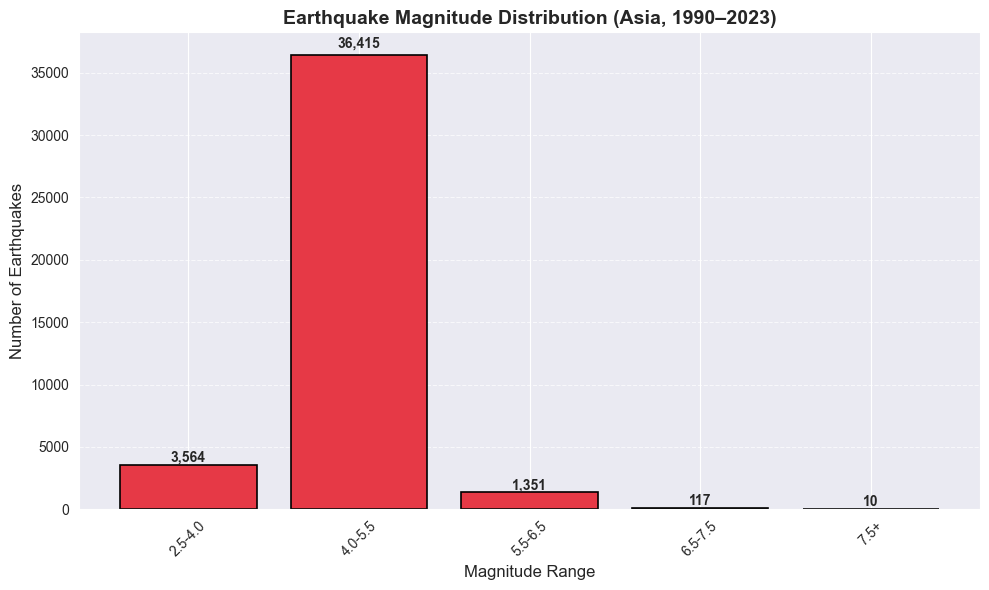

In [5]:
bins = [2.5, 4.0, 5.5, 6.5, 7.5, 10.0]
labels = ['2.5-4.0', '4.0-5.5', '5.5-6.5', '6.5-7.5', '7.5+']
df_raw['mag_bin'] = pd.cut(df_raw['mag'], bins=bins, labels=labels, right=False)
dist = df_raw['mag_bin'].value_counts().sort_index()
pct = (dist / len(df_raw) * 100).round(2)
plt.figure(figsize=(10, 6))
bars = plt.bar(dist.index, dist.values, color='#E63946', edgecolor='black', linewidth=1.2)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + height * 0.01,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
plt.title('Earthquake Magnitude Distribution (Asia, 1990–2023)', fontsize=14, fontweight='bold')
plt.xlabel('Magnitude Range', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df_raw = df_raw.drop(columns=['mag_bin'])


## Clean Data

Null value counts after cleaning:
 latitude      0
longitude     0
depth         0
mag           0
magType       0
nst           0
gap           0
rms           0
depthError    0
magNst        0
year          0
month         0
day           0
hour          0
dtype: int64


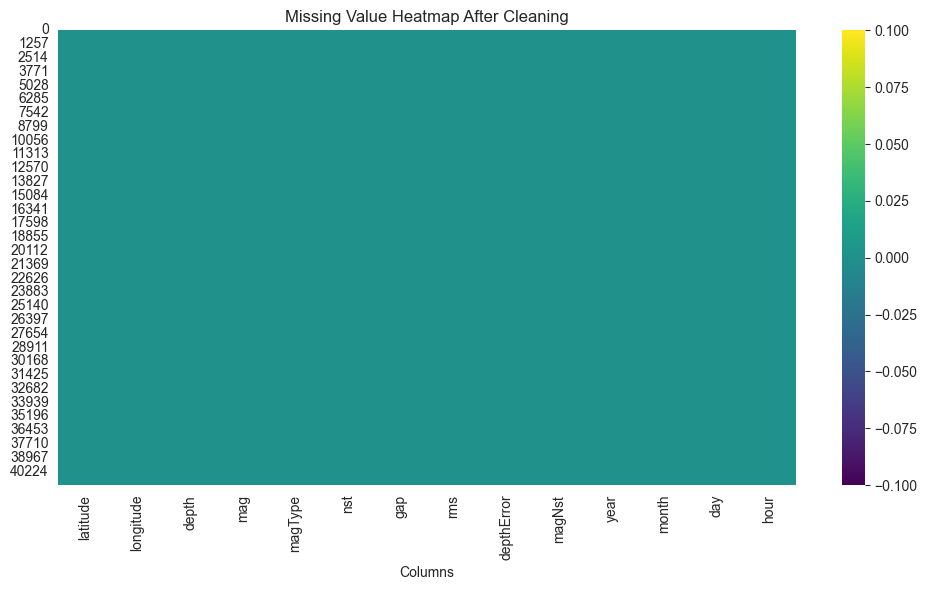

In [6]:
# Define target
target = 'mag'

# Drop irrelevant columns
cols_to_drop = [
    'id', 'updated', 'net', 'place', 'type', 'status', 'locationSource', 'magSource',
    'dmin', 'horizontalError', 'magError'
]
df_clean = df_raw.drop(columns=cols_to_drop)

# Convert time into numerical features
df_clean['time'] = pd.to_datetime(df_clean['time'])
df_clean['year'] = df_clean['time'].dt.year
df_clean['month'] = df_clean['time'].dt.month
df_clean['day'] = df_clean['time'].dt.day
df_clean['hour'] = df_clean['time'].dt.hour
df_clean = df_clean.drop(columns=['time'])

# Fill missing values
df_clean['nst'] = df_clean['nst'].fillna(df_clean['nst'].median())
df_clean['gap'] = df_clean['gap'].fillna(df_clean['gap'].median())
df_clean['rms'] = df_clean['rms'].fillna(df_clean['rms'].median())
df_clean['depthError'] = df_clean['depthError'].fillna(df_clean['depthError'].median())
df_clean['magNst'] = df_clean['magNst'].fillna(df_clean['magNst'].median())

# Verify no null values remain
print("Null value counts after cleaning:\n", df_clean.isnull().sum())
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.isnull(), cbar=True, cmap='viridis')
plt.title('Missing Value Heatmap After Cleaning')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

# One-hot encoding for magType
df_clean['magType'] = df_clean['magType'].fillna(df_clean['magType'].mode()[0])
top_types = ['mb', 'ml', 'md']
df_clean['magType_simple'] = df_clean['magType'].apply(lambda x: x if x in top_types else 'Other')
existing_mag_cols = [col for col in df_clean.columns if col.startswith('mag_')]
if existing_mag_cols:
    df_clean = df_clean.drop(columns=existing_mag_cols)
df_clean = pd.get_dummies(df_clean, columns=['magType_simple'], prefix='mag')
mag_columns = [col for col in df_clean.columns if col.startswith('mag_')]
df_clean[mag_columns] = df_clean[mag_columns].astype(int)
df_clean = df_clean.drop(columns=['magType'])


## Apply SMOTE

In [7]:
# Define features
features = [col for col in df_clean.columns if col != target]

# Store original magnitudes
original_mags = df_clean['mag'].copy()

# Discretize magnitude into binary class: < 6.0 vs. >= 6.0
df_clean['mag_class'] = (df_clean[target] >= 6.0).astype(int)

# Separate features and target class
X = df_clean[features]
y = df_clean['mag_class']

print("Class distribution before SMOTE:")
print(y.value_counts())

# Initialize SMOTE
smote = SMOTE(sampling_strategy={1: 10000}, random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(y_resampled.value_counts())
print(f"Total rows after SMOTE: {len(X_resampled)}")


Class distribution before SMOTE:
mag_class
0    40985
1      472
Name: count, dtype: int64
Class distribution after SMOTE:
mag_class
0    40985
1    10000
Name: count, dtype: int64
Total rows after SMOTE: 50985


## Reconstruct DataFrame

In [8]:
# Create new DataFrame with resampled data
df_resampled = pd.DataFrame(X_resampled, columns=features)
df_resampled['mag_class'] = y_resampled

# Assign magnitudes
max_mag = df_raw['mag'].max()
num_original = len(original_mags)
df_resampled['mag'] = np.concatenate([
    original_mags,
    np.random.uniform(6.0, max_mag, size=len(df_resampled) - num_original)
])

# Drop the temporary class column
df_resampled = df_resampled.drop(columns=['mag_class'])

print("Resampled magnitude stats:\n", df_resampled['mag'].describe())


Resampled magnitude stats:
 count    50985.000000
mean         5.053232
std          1.326014
min          2.700000
25%          4.300000
50%          4.500000
75%          5.100000
max          9.100000
Name: mag, dtype: float64


## Downsample 4.0-5.5 Magnitude Range

In [9]:
# Define bins and labels
bins = [2.5, 4.0, 5.5, 6.5, 7.5, 10.0]
labels = ['2.5-4.0', '4.0-5.5', '5.5-6.5', '6.5-7.5', '7.5+']

# Group magnitudes into bins
df_resampled['mag_bin'] = pd.cut(df_resampled['mag'], bins=bins, labels=labels, right=False)

# Get current distribution
dist = df_resampled['mag_bin'].value_counts().sort_index()
print("Current magnitude distribution before downsampling:\n", dist)

# Downsample 4.0-5.5 to 10,000 rows
target_count = 10000
if dist.get('4.0-5.5', 0) > target_count:
    mask_4_5_5 = (df_resampled['mag_bin'] == '4.0-5.5')
    df_4_5_5 = df_resampled[mask_4_5_5].sample(n=target_count, random_state=42)
    df_resampled = pd.concat([df_resampled[~mask_4_5_5], df_4_5_5]).reset_index(drop=True)

# Update distribution after downsampling
df_resampled['mag_bin'] = pd.cut(df_resampled['mag'], bins=bins, labels=labels, right=False)
dist_downsampled = df_resampled['mag_bin'].value_counts().sort_index()
print("Downsampled magnitude distribution (4.0-5.5 to 10,000):\n", dist_downsampled)


Current magnitude distribution before downsampling:
 mag_bin
2.5-4.0     3564
4.0-5.5    36415
5.5-6.5     2954
6.5-7.5     3137
7.5+        4915
Name: count, dtype: int64
Downsampled magnitude distribution (4.0-5.5 to 10,000):
 mag_bin
2.5-4.0     3564
4.0-5.5    10000
5.5-6.5     2954
6.5-7.5     3137
7.5+        4915
Name: count, dtype: int64


## Feature Engineering on Resampled Data

In [10]:
# Cyclical time features
df_resampled['month_sin'] = np.sin(2 * np.pi * df_resampled['month'] / 12)
df_resampled['month_cos'] = np.cos(2 * np.pi * df_resampled['month'] / 12)
df_resampled['hour_sin'] = np.sin(2 * np.pi * df_resampled['hour'] / 24)
df_resampled['hour_cos'] = np.cos(2 * np.pi * df_resampled['hour'] / 24)

# Create clusters
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df_resampled['region'] = kmeans.fit_predict(df_resampled[['latitude', 'longitude']])

# Drop original month and hour
df_resampled = df_resampled.drop(columns=['month', 'hour', 'day'], errors='ignore')

print("Resampled dataset info after feature engineering:\n", df_resampled.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24570 entries, 0 to 24569
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   latitude    24570 non-null  float64 
 1   longitude   24570 non-null  float64 
 2   depth       24570 non-null  float64 
 3   nst         24570 non-null  float64 
 4   gap         24570 non-null  float64 
 5   rms         24570 non-null  float64 
 6   depthError  24570 non-null  float64 
 7   magNst      24570 non-null  float64 
 8   year        24570 non-null  int32   
 9   mag_Other   24570 non-null  int64   
 10  mag_mb      24570 non-null  int64   
 11  mag_ml      24570 non-null  int64   
 12  mag         24570 non-null  float64 
 13  mag_bin     24570 non-null  category
 14  month_sin   24570 non-null  float64 
 15  month_cos   24570 non-null  float64 
 16  hour_sin    24570 non-null  float64 
 17  hour_cos    24570 non-null  float64 
 18  region      24570 non-null  int32   
dtypes: c

## Save Oversampled Dataset

In [11]:
os.makedirs('oversampled', exist_ok=True)
df_resampled.to_csv('oversampled/japan_earthquake_oversampled_with_features.csv', index=False)
print("✅ Oversampled dataset with features saved successfully!")


✅ Oversampled dataset with features saved successfully!


## Optional: Verify Distribution

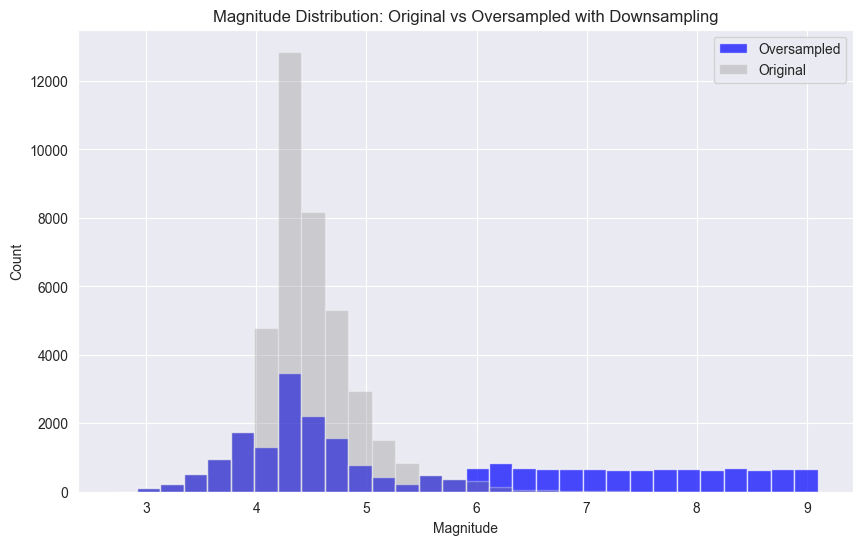

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(df_resampled['mag'], bins=30, color='blue', alpha=0.7, label='Oversampled')
plt.hist(df_raw['mag'], bins=30, color='gray', alpha=0.3, label='Original')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.title('Magnitude Distribution: Original vs Oversampled with Downsampling')
plt.legend()
plt.show()


## Compare Target Magnitude with Other Features

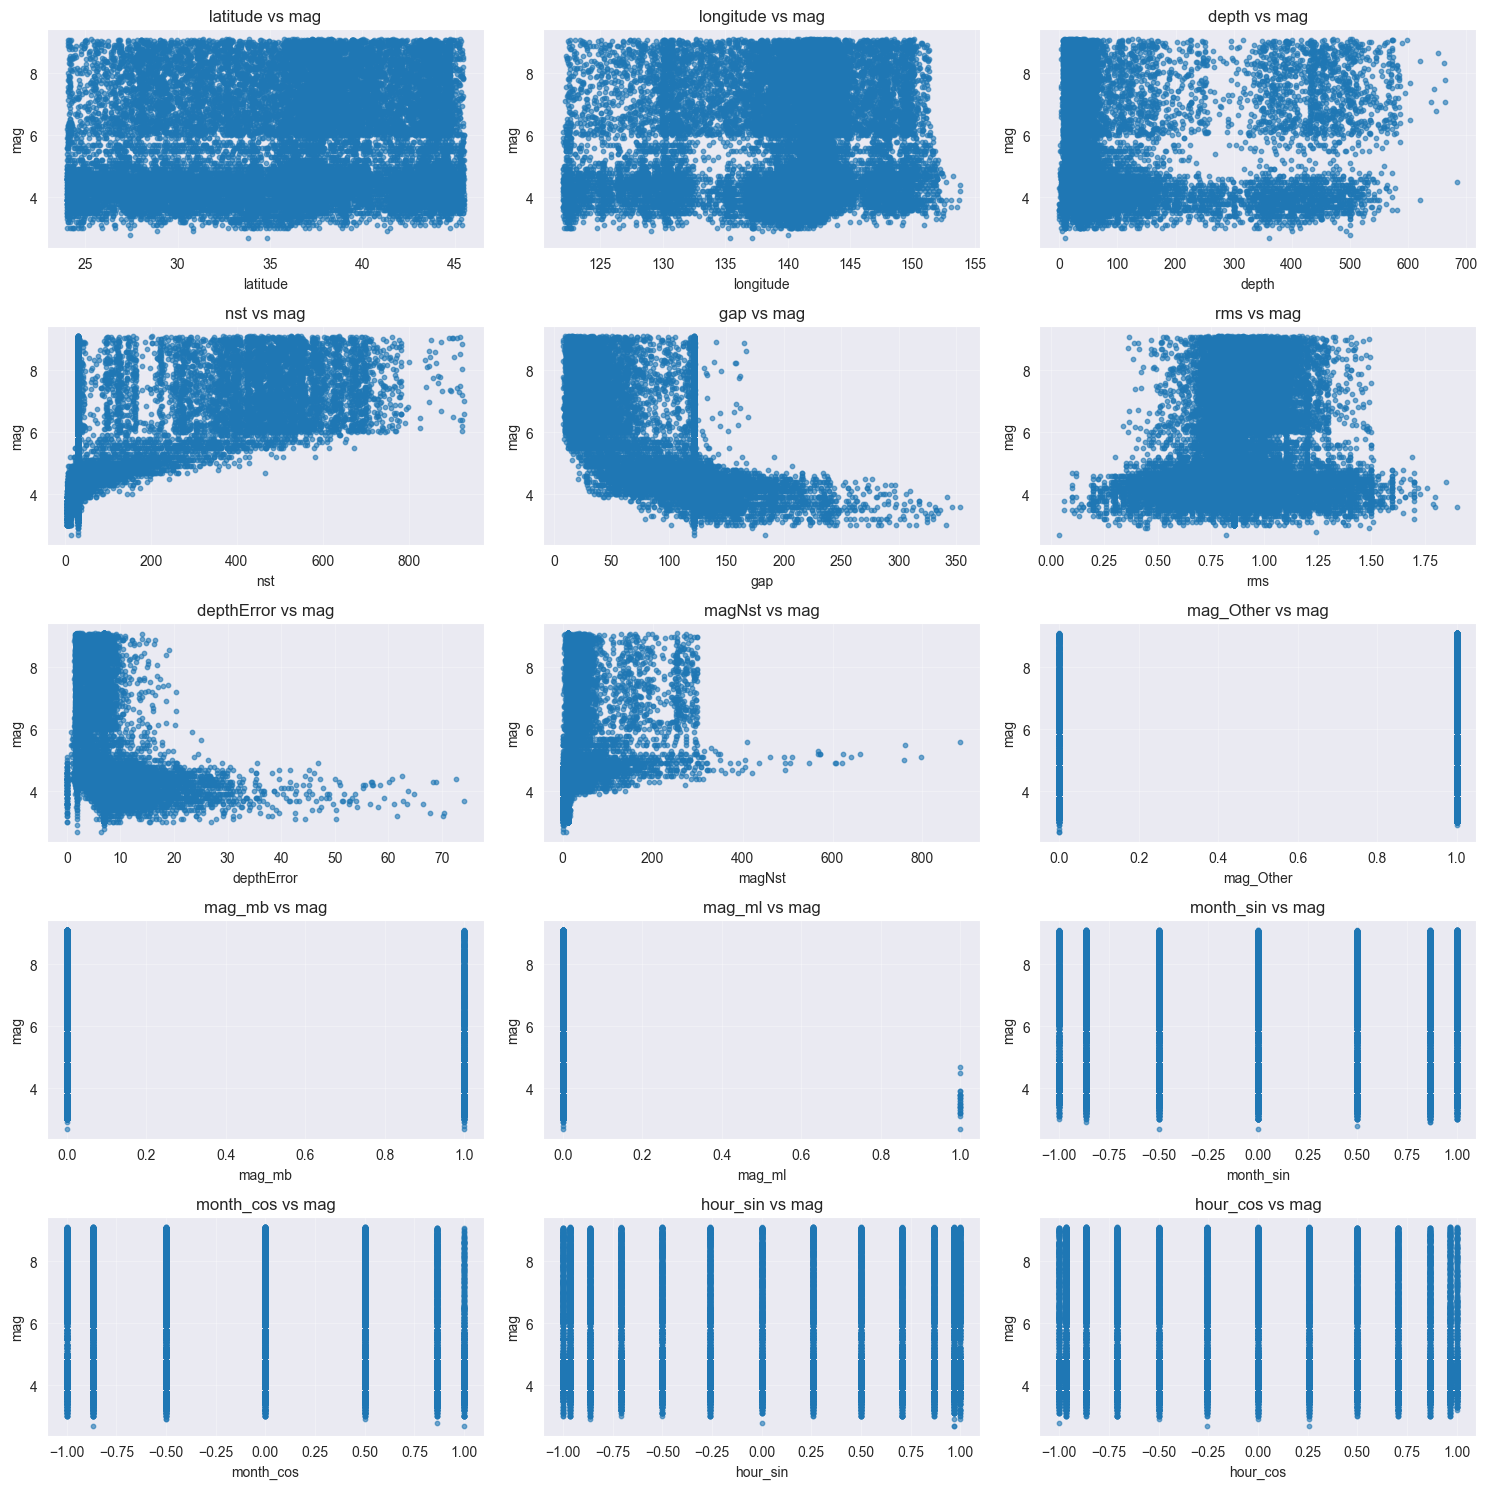

In [13]:
numerical_features = df_resampled.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove(target)

plt.figure(figsize=(15, 3 * math.ceil(len(numerical_features) / 3)))
for i, col in enumerate(numerical_features):
    plt.subplot(math.ceil(len(numerical_features) / 3), 3, i + 1)
    plt.scatter(df_resampled[col], df_resampled[target], alpha=0.6, s=10)
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f'{col} vs {target}')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Mag Plot

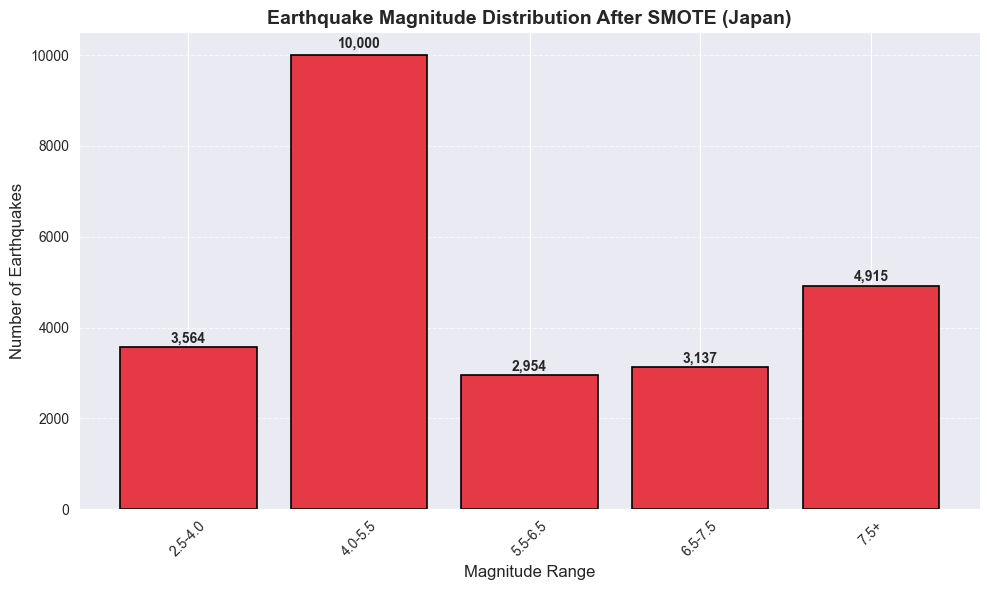

In [14]:
# Define bins and labels for magnitude distribution
bins = [2.5, 4.0, 5.5, 6.5, 7.5, 10.0]
labels = ['2.5-4.0', '4.0-5.5', '5.5-6.5', '6.5-7.5', '7.5+']

# Group magnitudes into bins for the resampled data
df_resampled['mag_bin'] = pd.cut(df_resampled['mag'], bins=bins, labels=labels, right=False)

# Get counts and percentages
dist = df_resampled['mag_bin'].value_counts().sort_index()
pct = (dist / len(df_resampled) * 100).round(2)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(dist.index, dist.values, color='#E63946', edgecolor='black', linewidth=1.2)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + height * 0.01,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.title('Earthquake Magnitude Distribution After SMOTE (Japan)', fontsize=14, fontweight='bold')
plt.xlabel('Magnitude Range', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Drop the temporary mag_bin column
df_resampled = df_resampled.drop(columns=['mag_bin'])